In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# Function to calculate carbon emissions based on given fields
def calculate_carbon_emission(row):
    # Constants for carbon emissions factors (hypothetical values for demonstration)
    carbon_factors = {
        'Raw Material Weight (tons)': 0.1,
        'Energy Consumption (kWh)': 0.5,
        'Water Usage (gallons)': 0.2,
        'Chemical Usage (liters)': 0.3,
        'Furnace Temperature (°C)': 0.4,
        'Production Time (hours)': 0.2,
        'Yield (%)': 0.1,
        'Scrap Metal (tons)': 0.1,
        'Maintenance Downtime (hours)': 0.3
    }

    # Calculate total carbon emission for the row
    total_emission = sum(row[field] * factor for field, factor in carbon_factors.items())

    return total_emission

# Input and output file paths
input_file = 'dataset.csv'  # Replace with your input CSV file path
output_file = 'carbon_emission.csv'  # Replace with your desired output CSV file path

# Read input CSV file into a pandas DataFrame
data = pd.read_csv(input_file)

# Calculate carbon emission for each row
data['Estimated Carbon Emission'] = data.apply(calculate_carbon_emission, axis=1)

# Select only Date and Estimated Carbon Emission columns
output_data = data[['Date', 'Estimated Carbon Emission']]

# Save results to output CSV file
output_data.to_csv(output_file, index=False)

print(f"Estimated carbon emissions calculated and saved to {output_file}.")

Estimated carbon emissions calculated and saved to carbon_emission.csv.


In [5]:
# Step 1: Read the CSV file
df = pd.read_csv('carbon_emission.csv')

# Step 2: Preprocess the data
# Convert dates to ordinal numbers
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).map(pd.Timestamp.toordinal)
# Normalize the total carbon emission amounts
scaler = MinMaxScaler(feature_range=(0, 1))
df['Estimated Carbon Emission'] = scaler.fit_transform(df[['Estimated Carbon Emission']])

# Step 3: Split the data
X = df['Date'].values.reshape(-1, 1)
y = df['Estimated Carbon Emission'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015), loss='mean_squared_error')

# Step 6: Train the model
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

# Step 7: Evaluate the model
model.evaluate(X_test, y_test)


# Get user input
month_year_str = input("Enter month and year (YYYY-MM): ")
year, month = map(int, month_year_str.split('-'))

# Generate all Wednesdays of the specified month
first_day = datetime(year, month, 1)
last_day = (first_day.replace(month=month % 12 + 1, day=1) - timedelta(days=1)).day
days = [first_day + timedelta(days=i) for i in range(last_day)]

# Prepare the data for prediction
day_ordinals = np.array([datetime.toordinal(day) for day in days]).reshape(-1, 1)
predicted_emissions = model.predict(day_ordinals)
predicted_emissions = scaler.inverse_transform(predicted_emissions)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Date': [day.strftime("%Y-%m-%d") for day in days],
    'Predicted Carbon Emission': predicted_emissions.flatten()
})

# Save the results to a CSV file
csv_filename = f"predicted_emissions_{year}_{month:02d}.csv"
results.to_csv(csv_filename, index=False)

print(f"Predicted carbon emissions saved to {csv_filename}")

Epoch 1/150
4/4 [==============================] - 1s 62ms/step - loss: 2043924608.0000 - val_loss: 2162014208.0000
Epoch 2/150
4/4 [==============================] - 0s 11ms/step - loss: 1222799872.0000 - val_loss: 15110672.0000
Epoch 3/150
4/4 [==============================] - 0s 12ms/step - loss: 479897824.0000 - val_loss: 763558912.0000
Epoch 4/150
4/4 [==============================] - 0s 13ms/step - loss: 342358624.0000 - val_loss: 58579280.0000
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 259278096.0000 - val_loss: 293865600.0000
Epoch 6/150
4/4 [==============================] - 0s 11ms/step - loss: 118119128.0000 - val_loss: 56430528.0000
Epoch 7/150
4/4 [==============================] - 0s 11ms/step - loss: 135767376.0000 - val_loss: 102981560.0000
Epoch 8/150
4/4 [==============================] - 0s 20ms/step - loss: 38161820.0000 - val_loss: 51885528.0000
Epoch 9/150
4/4 [==============================] - 0s 11ms/step - loss: 70229880.0000 - va

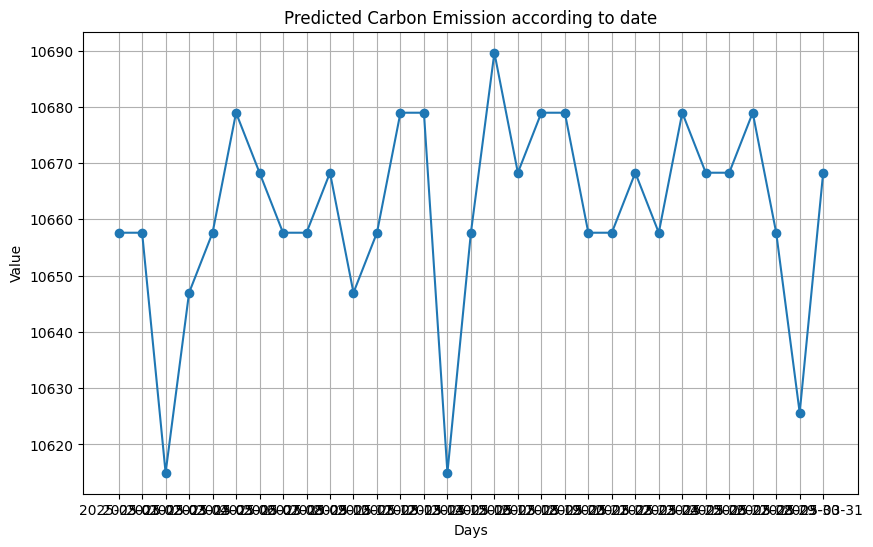

In [6]:
# Step 1: Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_filename)

# Step 2: Extract x and y values from the DataFrame
days = df['Date']
values = df['Predicted Carbon Emission']

# Step 3: Plot the data
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

plt.plot(days, values, marker='o', linestyle='-')

# Step 4: Customize the plot (optional)
plt.title('Predicted Carbon Emission according to date')
plt.xlabel('Days')
plt.ylabel('Value')
plt.grid(True)

# Step 5: Show the plot
plt.show()

In [7]:
data = pd.read_csv(csv_filename)

# Identify the most frequent predicted carbon emission value
most_frequent_value = data['Predicted Carbon Emission'].mode()[0]

# Calculate dynamic thresholds based on percentiles
thresholds = {
    'A': data['Predicted Carbon Emission'].quantile(0.25),
    'B': data['Predicted Carbon Emission'].quantile(0.50),
    'C': data['Predicted Carbon Emission'].quantile(0.75)
}

# Function to assign grades based on dynamic thresholds
def assign_grade(emission, thresholds):
    if emission < thresholds['A']:
        return 'A'
    elif thresholds['A'] <= emission < thresholds['B']:
        return 'B'
    elif thresholds['B'] <= emission < thresholds['C']:
        return 'C'
    else:
        return 'D'

# Function to suggest improvements based on grade
def suggest_improvements(grade):
    suggestions = {
        'A': 'Maintain current practices.',
        'B': 'Increase efficiency in energy use, consider renewable energy sources.',
        'C': 'Implement strict emission control measures, adopt green technologies.',
        'D': 'Immediate action needed: overhaul systems, invest heavily in sustainable practices.'
    }
    return suggestions[grade]

# Assign grade to the most frequent predicted carbon emission value
grade = assign_grade(most_frequent_value, thresholds)

# Generate suggestion based on the grade
suggestion = suggest_improvements(grade)

# Output the results
most_frequent_value, grade, suggestion
print("Grade : ",grade)
print("Suggestion : ",suggestion)


Grade :  C
Suggestion :  Implement strict emission control measures, adopt green technologies.
